# **Assignment : Anime Recommended System**

- 62010278 ณัฐพนธ์ สุขถาวร 
- 62010497 นิธิ น้อมประวัติ 
- 62010609 พักตร์ภูมิ ตาแพร่ 
- 62010948 สิรวิชญ์ สุขวัฒนาวิทย์ 

## **Import Libraries**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from collections import defaultdict
from sklearn.metrics import roc_curve, auc
from tqdm.auto import tqdm

## **Import Datasets**

In [4]:
ANIME_CSV_PATH = "./datasets/anime.csv"
RATING_CSV_PATH = "./datasets/rating.csv"


In [5]:
anime_df = pd.read_csv(ANIME_CSV_PATH)

rating_df = pd.read_csv(RATING_CSV_PATH)

## **Data Exploration**

In [6]:
print(f"Number of unique users : {rating_df['user_id'].nunique()}")

Number of unique users: 73515


In [7]:
print(f"Number of unique animes : {rating_df['anime_id'].nunique()}")

Number of unique animes: 11200


## **Data Processing**

In [5]:
rating_df = rating_df[rating_df['rating'] >= 0]

In [6]:
user_grouped = rating_df.groupby(['anime_id'])['user_id'].count().reset_index(name='num_user')
user_grouped

,anime_id,num_user
0,1,13449
1,5,5790
2,6,9385
3,7,2169
4,8,308
...,...,...
9922,34324,11
9923,34325,15
9924,34349,3
9925,34367,4


In [7]:
median_num_user = user_grouped['num_user'].median()
median_num_user

57.0

Text(5, 2000, 'Cut off: 5')

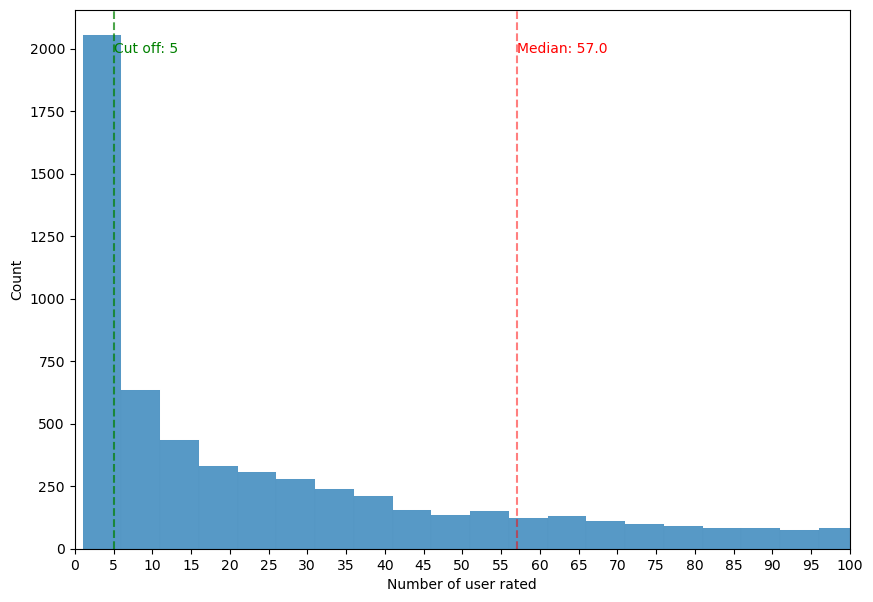

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(x='num_user', data=user_grouped, binwidth=5)
plt.xlim(0, 100)
ax.set_xticks(np.arange(0, 105, 5))
ax.set_xlabel("Number of user rated")
ax.axvline(median_num_user, color='red', linestyle='--',
           alpha=.5)
ax.text(median_num_user, 2000, f"Median: {median_num_user}", va='center',
        ha='left', color='red')
ax.axvline(5, color='green', linestyle='--',
           alpha=.7)
ax.text(5, 2000, f"Cut off: 5", va='center',
        ha='left', color='green')

In [9]:
min_anime_id = user_grouped.loc[user_grouped['num_user'] >= 5, 'anime_id'].values
len(min_anime_id)

8030

In [10]:
min_rating_df = rating_df[rating_df['anime_id'].isin(min_anime_id)] 

In [11]:
user_grouped = min_rating_df.groupby(['user_id'])['anime_id'].count().reset_index(name='num_rate_anime')
user_grouped

,user_id,num_rate_anime
0,1,4
1,2,1
2,3,92
3,5,459
4,7,343
...,...,...
69594,73512,12
69595,73513,33
69596,73514,1
69597,73515,179


In [12]:
median_num_rate_anime = user_grouped['num_rate_anime'].median()
median_num_rate_anime

45.0

Text(10, 10700, 'Cut off: 10')

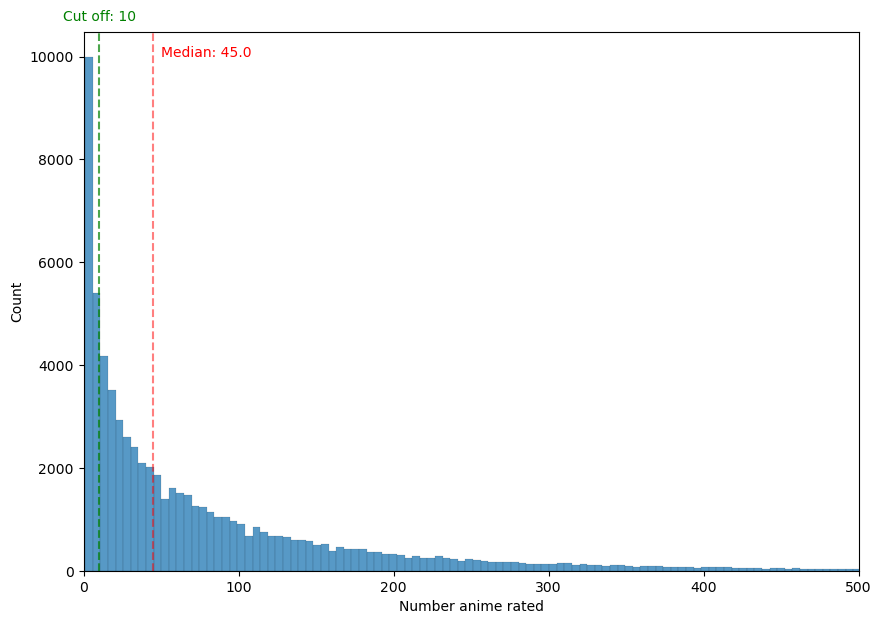

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(x='num_rate_anime', data=user_grouped)
plt.xlim(0, 500)
ax.set_xlabel("Number anime rated")
ax.axvline(median_num_rate_anime, color='red', linestyle='--',
           alpha=.5)
ax.text(median_num_rate_anime+5, 10000, f"Median: {median_num_rate_anime}", 
        ha='left', color='red')
ax.axvline(10, color='green', linestyle='--',
           alpha=.7)
ax.text(10, 10700, f"Cut off: 10", 
        ha='center', color='green')

In [14]:
min_user_id = user_grouped.loc[user_grouped['num_rate_anime'] >= 10, 'user_id'].values
len(min_user_id)

55118

In [15]:
min_rating_df = min_rating_df[min_rating_df['user_id'].isin(min_user_id)] 

In [16]:
anime_grouped_df = pd.merge(anime_df, rating_df, on='anime_id', suffixes=['_anime', '_user'])
anime_grouped_df = anime_grouped_df[['user_id', 'type']]
anime_grouped_df = anime_grouped_df.groupby(['type'])['user_id'].count().reset_index(name='rating_cnt')
anime_grouped_df = anime_grouped_df.sort_values(['rating_cnt'], ascending=False)

Text(0.5, 1.0, 'Top type anime based on number of users rated')

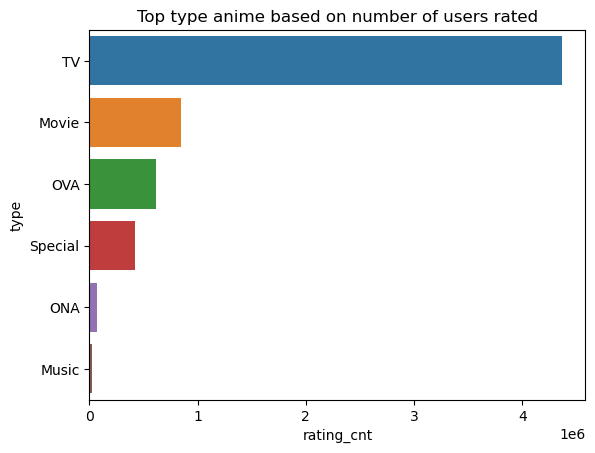

In [17]:
sns.barplot(y='type', x='rating_cnt', data=anime_grouped_df.head(10))
plt.title("Top type anime based on number of users rated")

In [18]:
anime_tv_df = anime_df[anime_df['type'] == 'TV']

In [19]:
merged_df = pd.merge(anime_tv_df, min_rating_df, on='anime_id', suffixes=['_anime', '_user'])

In [20]:
merged_df.groupby(['anime_id']).ngroups

2697

In [21]:
merged_df = merged_df[['user_id', 'name', 'rating_user']]
merged_df.shape

(4314988, 3)

In [22]:
merged_limit_df = merged_df[merged_df['user_id'] <= 20000]
merged_limit_df.shape

(1152353, 3)

## **Implmenting Core**

In [23]:
# Define the Reader object to parse the rating scale
reader = Reader(rating_scale=(0, 10))

In [24]:
# Load the data into the Surprise Dataset object
data = Dataset.load_from_df(merged_limit_df[['user_id', 'name', 'rating_user']], reader)

In [25]:
# param_grid = {
#   'n_factors': [20, 50, 100],
#   'n_epochs': [5, 10, 20]
# }

In [26]:
# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10)
# gs.fit(data)

In [27]:
# gs.best_score['mae']

In [28]:
# gs.best_params['mae']

In [29]:
# best_factor = gs.best_params['mae']['n_factors']
# best_epoch = gs.best_params['mae']['n_epochs']

In [30]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

In [31]:
# Define the SVD algorithm and fit it to the training set
algo = SVD(n_factors=50, n_epochs=20)
algo.fit(trainset)

In [32]:
# Predict the ratings for the test set
predictions = algo.test(testset)

## **Evaluation**

In [33]:
# Evaluate the accuracy of the predictions
accuracy.mae(predictions)

MAE:  0.8558


0.8557782462924641

In [34]:
# Get the top-k predictions for each user in the test set
top_k = defaultdict(list)
i = 0
for uid, iid, true_r, est, _ in predictions:
    top_k[uid].append((iid, est))

In [35]:
# Calculate the top-k precision for k = 10
k = 10
precision = 0
for uid, user_ratings in tqdm(top_k.items()):
    # Sort the user's predictions by estimated rating
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    # Get the top-k items for the user
    top_k_items = [j for (j, _) in user_ratings[:k]]
    # Get the items the user actually rated
    user_items = [item for (j, item, _) in testset if uid == j]
    # Calculate the precision for this user
    num_correct = len(set(top_k_items) & set(user_items))
    precision += num_correct / k
precision /= len(top_k)
print('Top-' + str(k) + ' precision:', precision)

  0%|          | 0/14656 [00:00<?, ?it/s]

Top-10 precision: 0.7336926855895269


In [36]:
# Calculate the AUC (area under the ROC curve)
y_true = [1 if r >= 7 else 0 for (_, _, r) in testset]
y_scores = [est for (_, _, _, est, _) in predictions]
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.8447867394588195
